In [32]:
from typing import List, Tuple
import torch
from torch.nn.utils.rnn import pad_sequence


def collate_pad(batch: List[Tuple[torch.Tensor, float, int]]):
    seqs, targets, lengths = zip(*batch)

    lengths_t = torch.tensor(lengths, dtype=torch.long)
    padded = pad_sequence(seqs, batch_first=True)
    targets_t = torch.tensor(targets, dtype=torch.float32)

    return padded.float(), lengths_t, targets_t


In [33]:
from torch.utils.data import DataLoader
from dataset import CmapssRandomCropDataset

def make_loader(sequences_by_unit, rul_by_unit, samples_per_epoch, batch_size, l_min, l_max, num_workers=0):
    ds = CmapssRandomCropDataset(
        sequences_by_unit=sequences_by_unit,
        rul_by_unit=rul_by_unit,
        samples_per_epoch=samples_per_epoch,
        l_min=l_min,
        l_max=l_max,
    )

    loader = DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=collate_pad,
        drop_last=True,
        pin_memory=True,
    )

    return loader


In [42]:
import torch
import torch.nn as nn


def train_one_epoch(model, loader, optimizer, device):
    model.train()
    loss_fn = nn.SmoothL1Loss()

    total_loss = 0.0
    n = 0

    for padded, lengths, targets in loader:
        padded = padded.to(device)
        lengths = lengths.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        preds = model(padded, lengths)
        loss = loss_fn(preds, targets)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        bs = targets.shape[0]
        total_loss += loss.item() * bs
        n += bs

    return total_loss / max(n, 1)


In [43]:
import pandas as pd

# The dataset has 26 columns
# 1. Unit Number (Which engine is it?)
# 2. Time Cycles (How long has it been running?)
# 3-5. Operational Settings (Altitude, Speed, etc.)
# 6-26. Sensor Readings (s1 to s21)

index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1, 22)] 
col_names = index_names + setting_names + sensor_names

print(col_names)

def load_fd(fd_tag):
    train_path = f"data/train_{fd_tag}.txt"
    test_path  = f"data/test_{fd_tag}.txt"
    rul_path   = f"data/RUL_{fd_tag}.txt"

    raw_train_df = pd.read_csv(train_path, sep=r'\s+', header=None, names=col_names)
    raw_test_df  = pd.read_csv(test_path,  sep=r'\s+', header=None, names=col_names)
    raw_rul_labels_df = pd.read_csv(rul_path, header=None, names=['RUL_truth'])

    # train labels: compute RUL from run-to-failure
    max_cycle = raw_train_df.groupby('unit_nr')['time_cycles'].max().rename('max_cycle')
    raw_train_df = raw_train_df.merge(max_cycle, left_on='unit_nr', right_index=True)
    raw_train_df['RUL'] = raw_train_df['max_cycle'] - raw_train_df['time_cycles']

    # test labels: provided separately
    return raw_train_df, raw_test_df, raw_rul_labels_df

next_unit = 1
train_dfs = []
test_dfs = []
test_rul_labels = []

data_tags = ["FD001","FD002","FD003","FD004"]
#data_tags = ["FD001", "FD003"]
data_tags = ["FD001"]

for fd_tag in data_tags:
    train_df_chunk, test_df_chunk, rul_labels_chunk = load_fd(fd_tag)
    train_df_chunk['fd'] = fd_tag
    test_df_chunk['fd'] = fd_tag
    test_df_chunk = test_df_chunk.assign(
        unit_nr_orig=test_df_chunk['unit_nr'],
        unit_nr=test_df_chunk['unit_nr'] + next_unit - 1
    )
    test_dfs.append(test_df_chunk)
    test_rul_labels.append(rul_labels_chunk)

    # make a mapping for this FD's units
    uniq_units = sorted(train_df_chunk['unit_nr'].unique())
    mapping = {u: next_unit + i for i, u in enumerate(uniq_units)}
    next_unit += len(uniq_units)

    train_df_chunk = train_df_chunk.assign(
        unit_nr_orig=train_df_chunk['unit_nr'],
        unit_nr=train_df_chunk['unit_nr'].map(mapping),
        fd=fd_tag
    )
    train_dfs.append(train_df_chunk)
    
    
train_df = pd.concat(train_dfs, ignore_index=True)
test_df = pd.concat(test_dfs, ignore_index=True)
rul_labels_df = pd.concat(test_rul_labels, ignore_index=True)

print(f"Train data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"RUL labels shape: {rul_labels_df.shape}")

engine_ids = train_df['unit_nr'].unique()

train_ids = engine_ids[:80]
val_ids = engine_ids[80:]
print("len train ids:", len(train_ids))
print("len val ids:", len(val_ids))
print("len engine ids:", len(engine_ids))

train_split_df = train_df[train_df['unit_nr'].isin(train_ids)]
val_split_df = train_df[train_df['unit_nr'].isin(val_ids)]
print("Train df shape:", train_split_df.shape)
print("Val df shape:", val_split_df.shape)




['unit_nr', 'time_cycles', 'setting_1', 'setting_2', 'setting_3', 's_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10', 's_11', 's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19', 's_20', 's_21']
Train data shape: (20631, 30)
Test data shape: (13096, 28)
RUL labels shape: (100, 1)
len train ids: 80
len val ids: 20
len engine ids: 100
Train df shape: (16138, 30)
Val df shape: (4493, 30)


EDA

In [44]:
# Missing values per column
missing = train_df.isna().mean().sort_values(ascending=False)
print(missing.head(10))

# Duplicate rows check
dup_count = train_df.duplicated().sum()
print("Duplicate rows:", dup_count)


unit_nr        0.0
time_cycles    0.0
setting_1      0.0
setting_2      0.0
setting_3      0.0
s_1            0.0
s_2            0.0
s_3            0.0
s_4            0.0
s_5            0.0
dtype: float64
Duplicate rows: 0


In [45]:
# Check cycle continuity per unit
gaps = []
for unit_id, g in train_df.groupby("unit_nr"):
    cycles = g["time_cycles"].sort_values().to_numpy()
    if not (cycles[0] == 1 and (cycles[1:] - cycles[:-1]).min() == 1):
        gaps.append(unit_id)

print("Units with non-continuous cycles:", len(gaps))


Units with non-continuous cycles: 0


In [46]:
# Per-unit lifetime distribution
lifetimes = train_df.groupby("unit_nr")["time_cycles"].max()
print(lifetimes.describe())

# RUL distribution
print(train_df["RUL"].describe())


count    100.000000
mean     206.310000
std       46.342749
min      128.000000
25%      177.000000
50%      199.000000
75%      229.250000
max      362.000000
Name: time_cycles, dtype: float64
count    20631.000000
mean       107.807862
std         68.880990
min          0.000000
25%         51.000000
50%        103.000000
75%        155.000000
max        361.000000
Name: RUL, dtype: float64


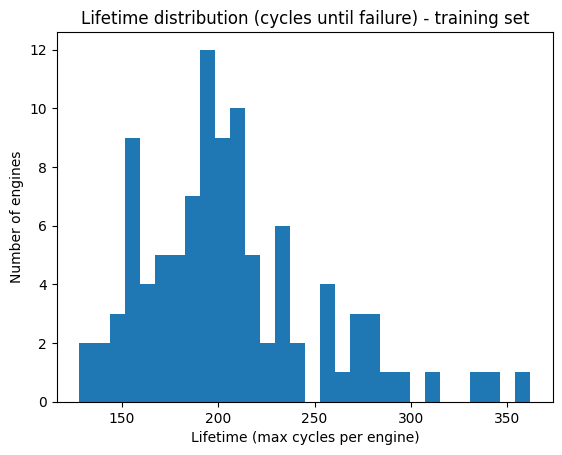

In [47]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(lifetimes, bins=30)
plt.title("Lifetime distribution (cycles until failure) - training set")
plt.xlabel("Lifetime (max cycles per engine)")
plt.ylabel("Number of engines")
plt.show()


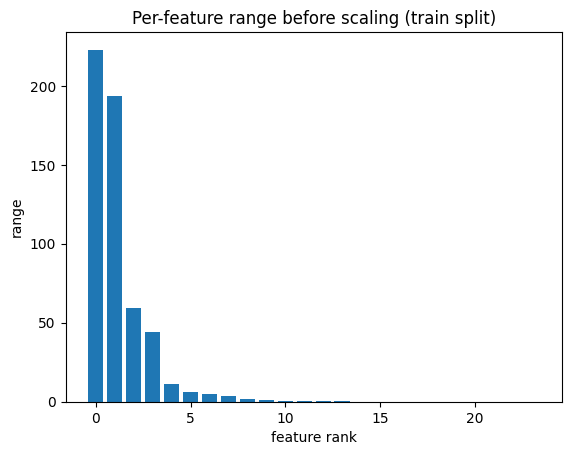

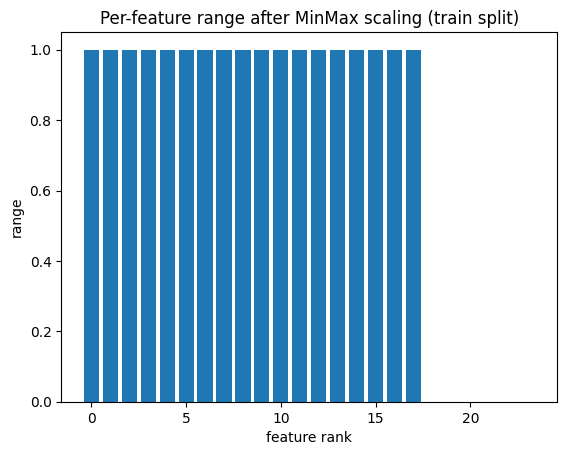

In [48]:
import matplotlib.pyplot as plt
import numpy as np 

columns_to_scale = setting_names + sensor_names

ranges = (train_split_df[columns_to_scale].max() - train_split_df[columns_to_scale].min()).sort_values(ascending=False)

plt.figure()
plt.bar(np.arange(len(ranges)), ranges.to_numpy())
plt.title("Per-feature range before scaling (train split)")
plt.xlabel("feature rank")
plt.ylabel("range")
plt.show()

scaled_ranges = (scaled_train_split_df[columns_to_scale].max() - scaled_train_split_df[columns_to_scale].min()).sort_values(ascending=False)

plt.figure()
plt.bar(np.arange(len(scaled_ranges)), scaled_ranges.to_numpy())
plt.title("Per-feature range after MinMax scaling (train split)")
plt.xlabel("feature rank")
plt.ylabel("range")
plt.show()


In [49]:
test_df.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,fd,unit_nr_orig
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,FD001,1
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,FD001,1
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,FD001,1
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,FD001,1
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,FD001,1


In [50]:
rul_labels_df.head()

,RUL_truth
0,112
1,98
2,69
3,82
4,91


In [51]:
from sklearn.preprocessing import MinMaxScaler


not_scaled_cols = ['unit_nr', 'RUL', 'max_cycle', 'time_cycles']

col_set = set(col_names)
columns_to_scale = [col for col in col_names if col not in not_scaled_cols]

print("Columns to scale:", columns_to_scale)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_split = scaler.fit_transform(train_split_df[columns_to_scale])
scaled_train_split_df = pd.DataFrame(scaled_train_split, columns=columns_to_scale, index=train_split_df.index)
scaled_val_split = scaler.transform(val_split_df[columns_to_scale])
scaled_val_split_df = pd.DataFrame(scaled_val_split, columns=columns_to_scale, index=val_split_df.index)
scaled_test = scaler.transform(test_df[columns_to_scale])
scaled_test_df = pd.DataFrame(scaled_test, columns=columns_to_scale, index=test_df.index)


scaled_train_split_df.insert(0, 'unit_nr', train_split_df['unit_nr'])
scaled_train_split_df.insert(1, 'time_cycles', train_split_df['time_cycles'])
scaled_train_split_df.insert(len(scaled_train_split_df.columns), 'RUL', train_split_df['RUL'])
scaled_train_split_df.insert(len(scaled_train_split_df.columns), 'max_cycle', train_split_df['max_cycle'])

scaled_val_split_df.insert(0, 'unit_nr', val_split_df['unit_nr'])
scaled_val_split_df.insert(1, 'time_cycles', val_split_df['time_cycles'])
scaled_val_split_df.insert(len(scaled_val_split_df.columns), 'RUL', val_split_df['RUL'])
scaled_val_split_df.insert(len(scaled_val_split_df.columns), 'max_cycle', val_split_df['max_cycle'])

scaled_test_df.insert(0, 'unit_nr', test_df['unit_nr'])
scaled_test_df.insert(1, 'time_cycles', test_df['time_cycles'])




Columns to scale: ['setting_1', 'setting_2', 'setting_3', 's_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10', 's_11', 's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19', 's_20', 's_21']


In [52]:
scaled_test_df.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,0.630058,0.750000,0.0,0.0,0.545181,0.324675,0.269413,0.0,...,0.646055,0.220588,0.132160,0.308965,0.0,0.363636,0.0,0.0,0.551181,0.660998
1,1,2,0.341040,0.250000,0.0,0.0,0.150602,0.396674,0.222316,0.0,...,0.739872,0.264706,0.204768,0.213159,0.0,0.454545,0.0,0.0,0.677165,0.686650
2,1,3,0.514451,0.583333,0.0,0.0,0.376506,0.362269,0.322248,0.0,...,0.699360,0.220588,0.155640,0.458638,0.0,0.454545,0.0,0.0,0.724409,0.722080
3,1,4,0.739884,0.500000,0.0,0.0,0.370482,0.298018,0.408001,0.0,...,0.573561,0.250000,0.170090,0.257022,0.0,0.272727,0.0,0.0,0.661417,0.661281
4,1,5,0.578035,0.500000,0.0,0.0,0.391566,0.367965,0.332039,0.0,...,0.737740,0.220588,0.152751,0.300885,0.0,0.181818,0.0,0.0,0.653543,0.716978


In [53]:
scaled_train_split_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 16138 entries, 0 to 16137
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   unit_nr      16138 non-null  int64  
 1   time_cycles  16138 non-null  int64  
 2   setting_1    16138 non-null  float64
 3   setting_2    16138 non-null  float64
 4   setting_3    16138 non-null  float64
 5   s_1          16138 non-null  float64
 6   s_2          16138 non-null  float64
 7   s_3          16138 non-null  float64
 8   s_4          16138 non-null  float64
 9   s_5          16138 non-null  float64
 10  s_6          16138 non-null  float64
 11  s_7          16138 non-null  float64
 12  s_8          16138 non-null  float64
 13  s_9          16138 non-null  float64
 14  s_10         16138 non-null  float64
 15  s_11         16138 non-null  float64
 16  s_12         16138 non-null  float64
 17  s_13         16138 non-null  float64
 18  s_14         16138 non-null  float64
 19  s_15     

In [54]:
scaled_val_split_df.info()
scaled_val_split_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 4493 entries, 16138 to 20630
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   unit_nr      4493 non-null   int64  
 1   time_cycles  4493 non-null   int64  
 2   setting_1    4493 non-null   float64
 3   setting_2    4493 non-null   float64
 4   setting_3    4493 non-null   float64
 5   s_1          4493 non-null   float64
 6   s_2          4493 non-null   float64
 7   s_3          4493 non-null   float64
 8   s_4          4493 non-null   float64
 9   s_5          4493 non-null   float64
 10  s_6          4493 non-null   float64
 11  s_7          4493 non-null   float64
 12  s_8          4493 non-null   float64
 13  s_9          4493 non-null   float64
 14  s_10         4493 non-null   float64
 15  s_11         4493 non-null   float64
 16  s_12         4493 non-null   float64
 17  s_13         4493 non-null   float64
 18  s_14         4493 non-null   float64
 19  s_15  

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL,max_cycle
16138,81,1,0.208092,0.750000,0.0,0.0,0.250000,0.429938,0.411546,0.0,...,0.179792,0.464025,0.0,0.272727,0.0,0.0,0.559055,0.608560,239,240
16139,81,2,0.630058,0.666667,0.0,0.0,0.433735,0.346548,0.432647,0.0,...,0.208639,0.509427,0.0,0.363636,0.0,0.0,0.590551,0.620890,238,240
16140,81,3,0.468208,0.916667,0.0,0.0,0.403614,0.350422,0.238859,0.0,...,0.205439,0.489804,0.0,0.545455,0.0,0.0,0.692913,0.643282,237,240
16141,81,4,0.491329,0.500000,0.0,0.0,0.361446,0.543404,0.381668,0.0,...,0.227991,0.444017,0.0,0.363636,0.0,0.0,0.480315,0.727749,236,240
16142,81,5,0.635838,0.666667,0.0,0.0,0.662651,0.443153,0.461344,0.0,...,0.202652,0.277799,0.0,0.363636,0.0,0.0,0.692913,0.600907,235,240


In [ ]:
sequences_by_unit = {}
rul_by_unit = {}

#feature_cols = col_names[2:]  # Exclude 'unit_nr' and 'time_cycles'
features_to_drop = ['unit_nr', 'time_cycles', 'RUL', 'max_cycle', "s_1", "s_5", "s_10", "s_16", "s_18", "s_19"]
feature_cols = [c for c in col_names if c not in features_to_drop]

#Feature columns: ['setting_1', 'setting_2', 's_2', 's_3', 's_4', 's_6', 's_7', 's_8', 's_9', 's_11', 's_12', 's_13', 's_15', 's_17', 's_20', 's_21'] count features: 16


import torch

def build_unit_dicts(df, feature_cols):
    sequences_by_unit = {}
    rul_by_unit = {}

    df = df.sort_values(["unit_nr", "time_cycles"])

    for unit_id, g in df.groupby("unit_nr", sort=False):
        x = torch.tensor(g[feature_cols].to_numpy(), dtype=torch.float32)
        y = torch.tensor(g["RUL"].to_numpy(), dtype=torch.float32)

        sequences_by_unit[int(unit_id)] = x
        rul_by_unit[int(unit_id)] = y

    return sequences_by_unit, rul_by_unit

train_sequences_by_unit, train_rul_by_unit = build_unit_dicts(scaled_train_split_df, feature_cols)
val_sequences_by_unit, val_rul_by_unit = build_unit_dicts(scaled_val_split_df, feature_cols)

print("train_sequences_by_unit", len(train_sequences_by_unit))

from dataset import CmapssRandomCropDataset

dataset = CmapssRandomCropDataset(
    sequences_by_unit=train_sequences_by_unit,
    rul_by_unit=train_rul_by_unit,
    samples_per_epoch=1000,
    l_min=30,
    l_max=100,
)

seq, target, length = dataset[0]  # or dataset[42], same behavior
print(seq.shape, target, length)

train_loader = make_loader(train_sequences_by_unit, train_rul_by_unit, samples_per_epoch=60000, batch_size=32, l_min=30, l_max=100)
padded, lengths, targets = next(iter(train_loader))
print(padded.shape, lengths.shape, targets.shape)

val_loader = make_loader(val_sequences_by_unit, val_rul_by_unit, samples_per_epoch=14000, batch_size=32, l_min=30, l_max=200)
padded, lengths, targets = next(iter(val_loader))
print(padded.shape, lengths.shape, targets.shape)



train_sequences_by_unit 80
torch.Size([36, 18]) 127.0 36
torch.Size([32, 95, 18]) torch.Size([32]) torch.Size([32])
torch.Size([32, 172, 18]) torch.Size([32]) torch.Size([32])


In [63]:
scaled_train_split_df[feature_cols].head()

,setting_1,setting_2,setting_3,s_2,s_3,s_4,s_6,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21
0,0.456647,0.166667,0.0,0.183735,0.425154,0.309757,1.0,0.726248,0.242424,0.109755,0.365269,0.633262,0.205882,0.199608,0.363986,0.363636,0.708661,0.725482
1,0.606936,0.250000,0.0,0.283133,0.473456,0.352633,1.0,0.628019,0.212121,0.100242,0.377246,0.765458,0.279412,0.162813,0.411312,0.363636,0.661417,0.732001
2,0.248555,0.750000,0.0,0.343373,0.386193,0.370527,1.0,0.710145,0.272727,0.140043,0.245509,0.795309,0.220588,0.171793,0.357445,0.181818,0.622047,0.619473
3,0.537572,0.500000,0.0,0.343373,0.267715,0.331195,1.0,0.740741,0.318182,0.124518,0.161677,0.889126,0.294118,0.174889,0.166603,0.363636,0.566929,0.661565
4,0.387283,0.333333,0.0,0.349398,0.269082,0.404625,1.0,0.668277,0.242424,0.149960,0.251497,0.746269,0.235294,0.174734,0.402078,0.454545,0.582677,0.704790


In [56]:
import torch

def build_test_sequences(df, feature_cols):
    sequences = {}
    df = df.sort_values(["unit_nr", "time_cycles"])

    for unit_id, g in df.groupby("unit_nr", sort=False):
        x = torch.tensor(g[feature_cols].to_numpy(), dtype=torch.float32)
        sequences[int(unit_id)] = x

    return sequences

test_sequences_by_unit = build_test_sequences(scaled_test_df, feature_cols)

rul_truth = rul_labels_df["RUL_truth"].to_numpy().astype(float)
test_unit_ids = sorted(test_sequences_by_unit.keys())

test_targets_by_unit = {unit_id: float(rul_truth[i]) for i, unit_id in enumerate(test_unit_ids)}
print("test_sequences_by_unit", len(test_sequences_by_unit))
print("test_sequences_by_unit[0]", test_sequences_by_unit[1].shape)

test_sequences_by_unit 100
test_sequences_by_unit[0] torch.Size([31, 18])


In [66]:
print("Feature columns:", feature_cols,"count features:" ,len(feature_cols))
scaled_test_df.head()

Feature columns: ['setting_1', 'setting_2', 'setting_3', 's_2', 's_3', 's_4', 's_6', 's_7', 's_8', 's_9', 's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21'] count features: 18


,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,0.630058,0.750000,0.0,0.0,0.545181,0.324675,0.269413,0.0,...,0.646055,0.220588,0.132160,0.308965,0.0,0.363636,0.0,0.0,0.551181,0.660998
1,1,2,0.341040,0.250000,0.0,0.0,0.150602,0.396674,0.222316,0.0,...,0.739872,0.264706,0.204768,0.213159,0.0,0.454545,0.0,0.0,0.677165,0.686650
2,1,3,0.514451,0.583333,0.0,0.0,0.376506,0.362269,0.322248,0.0,...,0.699360,0.220588,0.155640,0.458638,0.0,0.454545,0.0,0.0,0.724409,0.722080
3,1,4,0.739884,0.500000,0.0,0.0,0.370482,0.298018,0.408001,0.0,...,0.573561,0.250000,0.170090,0.257022,0.0,0.272727,0.0,0.0,0.661417,0.661281
4,1,5,0.578035,0.500000,0.0,0.0,0.391566,0.367965,0.332039,0.0,...,0.737740,0.220588,0.152751,0.300885,0.0,0.181818,0.0,0.0,0.653543,0.716978


In [57]:
from torch.utils.data import Dataset

class CmapssLastWindowDataset(Dataset):
    def __init__(self, sequences_by_unit, targets_by_unit, window_len: int):
        self.sequences_by_unit = sequences_by_unit
        self.targets_by_unit = targets_by_unit
        self.window_len = window_len
        self.unit_ids = sorted(sequences_by_unit.keys())

    def __len__(self):
        return len(self.unit_ids)

    def __getitem__(self, idx):
        unit_id = self.unit_ids[idx]
        seq = self.sequences_by_unit[unit_id]
        target = self.targets_by_unit[unit_id]

        if self.window_len is not None and seq.shape[0] > self.window_len:
            seq = seq[-self.window_len:]

        length = int(seq.shape[0])
        return seq, float(target), length
    
class CmapssFullDataset(Dataset):
    def __init__(self, sequences_by_unit, targets_by_unit):
        self.sequences_by_unit = sequences_by_unit
        self.targets_by_unit = targets_by_unit
        self.unit_ids = sorted(sequences_by_unit.keys())

    def __len__(self):
        return len(self.unit_ids)

    def __getitem__(self, idx):
        unit_id = self.unit_ids[idx]
        seq = self.sequences_by_unit[unit_id]
        target = self.targets_by_unit[unit_id]

        length = int(seq.shape[0])
        return seq, float(target), length
    





In [58]:
from torch.utils.data import DataLoader

WINDOW_LEN = 100

test_ds = CmapssLastWindowDataset(
    sequences_by_unit=test_sequences_by_unit,
    targets_by_unit=test_targets_by_unit,
    window_len=WINDOW_LEN,
)

test_loader = DataLoader(
    test_ds,
    batch_size=32,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_pad,
    drop_last=False,
    pin_memory=True,
)

test_ds = CmapssFullDataset(
    sequences_by_unit=test_sequences_by_unit,
    targets_by_unit=test_targets_by_unit,
)

test_loader = DataLoader(
    test_ds,
    batch_size=32,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_pad,
    drop_last=False,
    pin_memory=True,
)


In [59]:
import torch
import torch.nn as nn

def run_epoch(model, loader, loss_fn, device, train: bool, optimizer=None):
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    total_samples = 0

    if train:
        context = torch.enable_grad()
    else:
        context = torch.no_grad()

    with context:
        for padded, lengths, targets in loader:
            padded = padded.to(device)
            lengths = lengths.to(device)
            targets = targets.to(device)

            preds = model(padded, lengths)
            loss = loss_fn(preds, targets)

            bs = targets.size(0)
            total_loss += loss.item() * bs
            total_samples += bs

            if train:
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

    return total_loss / max(total_samples, 1)


In [60]:
import copy
from pathlib import Path
import os

EPOCHS = 20

if not os.path.exists('models'):
    os.makedirs('models')

def train_full(model, train_loader, val_loader, optimizer, device):
    loss_fn = nn.SmoothL1Loss(reduction="mean")

    best_val = float("inf")
    best_state = None

    for epoch in range(EPOCHS):
        train_loss = run_epoch(
            model=model,
            loader=train_loader,
            loss_fn=loss_fn,
            device=device,
            train=True,
            optimizer=optimizer,
        )

        val_loss = run_epoch(
            model=model,
            loader=val_loader,
            loss_fn=loss_fn,
            device=device,
            train=False,
            optimizer=None,
        )

        print(
            f"Epoch {epoch+1}/{EPOCHS} "
            f"train_loss: {train_loss:.4f} | val_loss: {val_loss:.4f}"
        )

        if val_loss < best_val:
            best_val = val_loss
            best_state = copy.deepcopy(model.state_dict())

    if best_state is not None:
        model.load_state_dict(best_state)
        torch.save(best_state, 'models/lstm_model.pth')
        print("Model weights saved to models/lstm_model.pth")

    return best_val


In [ ]:
from model import RulLstm

model = RulLstm(
    n_features=len(feature_cols),
    hidden_size=128,
    num_layers=2,
    dropout=0.4,
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model.to(device)

#loss = train_one_epoch(model, dataset_loader, optimizer, device)

loss = train_full(model, train_loader, val_loader, optimizer, device)

Using device: cuda
Epoch 1/20 train_loss: 29.5864 | val_loss: 19.9457
Epoch 2/20 train_loss: 13.4691 | val_loss: 14.5422
Epoch 3/20 train_loss: 11.6197 | val_loss: 12.0002
Epoch 4/20 train_loss: 11.0894 | val_loss: 11.8018
Epoch 5/20 train_loss: 10.6434 | val_loss: 11.2499
Epoch 6/20 train_loss: 10.2801 | val_loss: 10.9924
Epoch 7/20 train_loss: 10.0444 | val_loss: 11.9471
Epoch 8/20 train_loss: 9.9101 | val_loss: 12.3228
Epoch 9/20 train_loss: 9.7568 | val_loss: 10.4217
Epoch 10/20 train_loss: 9.5315 | val_loss: 10.4863
Epoch 11/20 train_loss: 9.3758 | val_loss: 10.1875
Epoch 12/20 train_loss: 8.9552 | val_loss: 11.1516
Epoch 13/20 train_loss: 8.7201 | val_loss: 10.4700
Epoch 14/20 train_loss: 8.4707 | val_loss: 11.1693
Epoch 15/20 train_loss: 8.0917 | val_loss: 11.1589
Epoch 16/20 train_loss: 7.8524 | val_loss: 11.6155
Epoch 17/20 train_loss: 7.4850 | val_loss: 11.2294
Epoch 18/20 train_loss: 7.0831 | val_loss: 10.6012
Epoch 19/20 train_loss: 6.8362 | val_loss: 10.4333
Epoch 20/20 tr

In [ ]:
model.to("cpu")
model.eval()

x = torch.randn(32, 217, 18)
lengths = torch.full((32,), 217, dtype=torch.long)  # or whatever your lengths are

torch.onnx.export(
    model,
    (x, lengths),
    "models/lstm_model.onnx",
    input_names=["input", "lengths"],
    output_names=["output"],
    opset_version=18,
    dynamic_axes={
        "input": {0: "batch_size", 1: "sequence_length"},
        "lengths": {0: "batch_size"},
    },
    dynamo=False,  # optional but avoids dynamo issues
)


/tmp/ipykernel_1628759/386961691.py:7: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(
[W104 17:43:09.490489097 shape_type_inference.cpp:1994] Warning: The shape inference of prim::PackPadded type is missing, so it may result in wrong shape inference for the exported graph. Please consider adding it in symbolic function. (function UpdateReliable)
[W104 17:43:09.490504927 shape_type_inference.cpp:1994] Warning: The shape inference of prim::PackP

In [ ]:
import numpy as np
import onnxruntime as ort

sess = ort.InferenceSession("models/lstm_model.onnx", providers=["CPUExecutionProvider"])

x = np.random.randn(1, 30, 18).astype(np.float32)
lengths = np.array([30], dtype=np.int64)
y = sess.run(None, {"input": x, "lengths": lengths})
print("Inference successful")

Inference successful


In [ ]:
import numpy as np
import onnxruntime as ort

sess = ort.InferenceSession("models/lstm_model.onnx", providers=["CPUExecutionProvider"])

#x = np.random.randn(1, 30, 18).astype(np.float32)
#lengths = np.array([30], dtype=np.int64)

seq, target, length = test_ds[20]

print("Evaluating test sequence with shape:", seq.shape)
print("Length:", length)
print("Target RUL:", target)

seq = seq.numpy().reshape(1, -1, seq.shape[1])

lengths = np.array([length], dtype=np.int64)
outputs = sess.run(None, {"input": seq, "lengths": lengths})

print("Number of outputs:", len(outputs))
for i, out in enumerate(outputs):
    print(f"Output[{i}] shape:", out.shape, "dtype:", out.dtype)
    print(f"Output[{i}] data:", out.item())  # Print the actual output data

Evaluating test sequence with shape: torch.Size([148, 18])
Length: 148
Target RUL: 57.0
Number of outputs: 1
Output[0] shape: (1,) dtype: float32
Output[0] data: 53.588985443115234


Evaluating batch with padded shape: torch.Size([32, 217, 18])
Lengths: tensor([ 31,  49, 126, 106,  98, 105, 160, 166,  55, 192,  83, 217, 195,  46,
         76, 113, 165, 133, 135, 184, 148,  39, 130, 186,  48,  76, 140, 158,
        171, 143, 196, 145], device='cuda:0')
Evaluating batch with padded shape: torch.Size([32, 303, 18])
Lengths: tensor([ 50, 203, 198, 126, 121, 125,  37, 133, 123, 156, 172,  54, 152, 146,
         73,  78, 303,  74, 144, 189, 164, 121, 113, 136, 160, 176,  94, 147,
        159, 232, 155, 168], device='cuda:0')
Evaluating batch with padded shape: torch.Size([32, 244, 18])
Lengths: tensor([ 71, 147,  71, 187,  54, 152,  68, 131, 112, 137,  88, 205, 162,  72,
        101, 133, 213, 162,  73, 172,  34, 110,  56,  68, 177, 146, 234, 150,
        244, 133,  89,  97], device='cuda:0')
Evaluating batch with padded shape: torch.Size([32, 475, 18])
Lengths: tensor([134, 121,  97, 198, 233, 124, 234,  68, 138,  64, 158, 192, 238, 131,
        103, 146,  65, 169, 112,

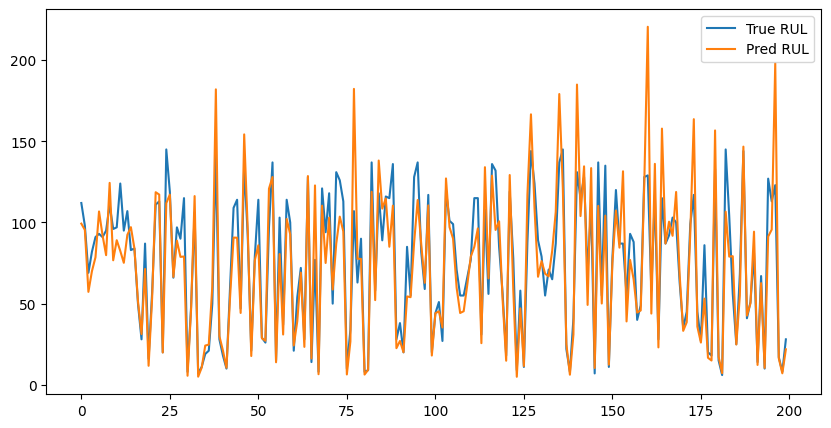

In [ ]:
import numpy as np
import torch
import torch.nn as nn

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()

    smoothl1 = nn.SmoothL1Loss(reduction="mean")
    l1 = nn.L1Loss(reduction="mean")
    mse = nn.MSELoss(reduction="mean")

    total_smoothl1 = 0.0
    total_l1 = 0.0
    total_mse = 0.0
    total_samples = 0

    all_preds = []
    all_targets = []

    for padded, lengths, targets in loader:
        padded = padded.to(device)
        lengths = lengths.to(device)
        targets = targets.to(device)
        
        print("Evaluating batch with padded shape:", padded.shape)
        print("Lengths:", lengths)
        preds = model(padded, lengths)

        bs = targets.size(0)
        total_smoothl1 += smoothl1(preds, targets).item() * bs
        total_l1 += l1(preds, targets).item() * bs
        total_mse += mse(preds, targets).item() * bs
        total_samples += bs

        all_preds.append(preds.detach().cpu())
        all_targets.append(targets.detach().cpu())

    mean_smoothl1 = total_smoothl1 / max(total_samples, 1)
    mean_mae = total_l1 / max(total_samples, 1)
    mean_rmse = float(np.sqrt(total_mse / max(total_samples, 1)))

    preds_cat = torch.cat(all_preds).numpy()
    targets_cat = torch.cat(all_targets).numpy()

    return mean_smoothl1, mean_mae, mean_rmse, preds_cat, targets_cat

smoothl1_loss, mae, rmse, preds, targets = evaluate(model, test_loader, device)

print(f"Test SmoothL1: {smoothl1_loss:.4f}")
print(f"Test MAE:      {mae:.4f}")
print(f"Test RMSE:     {rmse:.4f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(targets, label="True RUL")
plt.plot(preds, label="Pred RUL")
plt.legend()
plt.show()



In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

@torch.no_grad()
def plot_single_test_unit_last_prediction(
    model,
    scaled_test_df,
    rul_labels_df,
    feature_cols,
    unit_id: int,
    device: torch.device,
):
    g = scaled_test_df[scaled_test_df["unit_nr"] == unit_id].sort_values("time_cycles")
    if len(g) == 0:
        raise ValueError(f"unit_id {unit_id} not found in scaled_test_df")

    full_seq = torch.tensor(g[feature_cols].to_numpy(), dtype=torch.float32)
    cycles = g["time_cycles"].to_numpy().astype(int)

    last_cycle = int(cycles[-1])

    test_unit_ids = sorted(scaled_test_df["unit_nr"].unique().tolist())
    unit_idx = test_unit_ids.index(unit_id)

    true_rul_last = float(rul_labels_df["RUL_truth"].iloc[unit_idx])

    failure_cycle = last_cycle + true_rul_last
    true_rul_curve = (failure_cycle - cycles).astype(float)

    padded = full_seq.unsqueeze(0).to(device)
    lengths = torch.tensor([full_seq.shape[0]], dtype=torch.long, device=device)

    model.eval()
    pred_rul_last = float(model(padded, lengths)[0].item())

    plt.figure(figsize=(12, 6))
    plt.plot(cycles, true_rul_curve, label="True RUL (derived)")
    plt.scatter([last_cycle], [true_rul_last], label="True RUL at last cycle")
    plt.scatter([last_cycle], [pred_rul_last], label="Predicted RUL at last cycle")
    plt.xlabel("Cycle")
    plt.ylabel("RUL")
    plt.title(f"Test unit {unit_id} | last_cycle={last_cycle} | true_last={true_rul_last:.2f} | pred_last={pred_rul_last:.2f}")
    plt.legend()
    plt.show()

    return pred_rul_last, true_rul_last

pred_last, true_last = plot_single_test_unit_last_prediction(
    model=model,
    scaled_test_df=scaled_test_df,
    rul_labels_df=rul_labels_df,
    feature_cols=feature_cols,
    unit_id=3,
    device=device,
)
print("pred_last:", pred_last, "true_last:", true_last)


In [ ]:
def list_test_unit_ids(scaled_test_df):
    return sorted(scaled_test_df["unit_nr"].unique().tolist())

def show_unit(model, scaled_test_df, rul_labels_df, feature_cols, device, unit_id):
    pred_last, true_last = plot_single_test_unit_last_prediction(
        model=model,
        scaled_test_df=scaled_test_df,
        rul_labels_df=rul_labels_df,
        feature_cols=feature_cols,
        unit_id=unit_id,
        device=device,
    )
    print(f"unit_id={unit_id} pred_last={pred_last:.2f} true_last={true_last:.2f}")

unit_ids = list_test_unit_ids(scaled_test_df)
show_unit(model, scaled_test_df, rul_labels_df, feature_cols, device, unit_ids[0])
show_unit(model, scaled_test_df, rul_labels_df, feature_cols, device, unit_ids[1])


In [ ]:
import math
import numpy as np
import torch
import matplotlib.pyplot as plt

@torch.no_grad()
def plot_many_units_last_prediction(
    model,
    scaled_test_df,
    rul_labels_df,
    feature_cols,
    device,
    unit_ids,
    cols=3,
):
    model.eval()

    test_unit_ids_all = sorted(scaled_test_df["unit_nr"].unique().tolist())

    n = len(unit_ids)
    rows = int(math.ceil(n / cols))
    plt.figure(figsize=(5 * cols, 4 * rows))

    for i, unit_id in enumerate(unit_ids, start=1):
        g = scaled_test_df[scaled_test_df["unit_nr"] == unit_id].sort_values("time_cycles")
        if len(g) == 0:
            continue

        full_seq = torch.tensor(g[feature_cols].to_numpy(), dtype=torch.float32)
        cycles = g["time_cycles"].to_numpy().astype(int)
        last_cycle = int(cycles[-1])

        unit_idx = test_unit_ids_all.index(unit_id)
        true_rul_last = float(rul_labels_df["RUL_truth"].iloc[unit_idx])

        failure_cycle = last_cycle + true_rul_last
        true_rul_curve = (failure_cycle - cycles).astype(float)

        padded = full_seq.unsqueeze(0).to(device)
        lengths = torch.tensor([full_seq.shape[0]], dtype=torch.long, device=device)
        pred_rul_last = float(model(padded, lengths)[0].item())

        ax = plt.subplot(rows, cols, i)
        ax.plot(cycles, true_rul_curve, label="True")
        ax.scatter([last_cycle], [true_rul_last], label="True last")
        ax.scatter([last_cycle], [pred_rul_last], label="Pred last")
        ax.set_title(f"Unit {unit_id} | true={true_rul_last:.1f} pred={pred_rul_last:.1f}")
        ax.set_xlabel("Cycle")
        ax.set_ylabel("RUL")

        if i == 1:
            ax.legend()

    plt.tight_layout()
    plt.show()


unit_ids = sorted(scaled_test_df["unit_nr"].unique())
plot_many_units_last_prediction(
    model=model,
    scaled_test_df=scaled_test_df,
    rul_labels_df=rul_labels_df,
    feature_cols=feature_cols,
    device=device,
    unit_ids=unit_ids[:9],
    cols=3,
)


In [61]:
import itertools
import random
import numpy as np
import torch
from model import RulLstm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def run_trial(params, seed=0):
    set_seed(seed)

    train_loader = make_loader(
        train_sequences_by_unit,
        train_rul_by_unit,
        samples_per_epoch=params["samples_per_epoch"],
        batch_size=params["batch_size"],
        l_min=params["l_min"],
        l_max=params["l_max"],
    )
    val_loader = make_loader(
        val_sequences_by_unit,
        val_rul_by_unit,
        samples_per_epoch=params.get("val_samples_per_epoch", 14000),
        batch_size=params["batch_size"],
        l_min=params["l_min"],
        l_max=params.get("val_l_max", params["l_max"]),
    )

    model = RulLstm(
        n_features=len(feature_cols),
        hidden_size=params["hidden_size"],
        num_layers=params["num_layers"],
        dropout=params["dropout"],
    ).to(device)

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=params["lr"],
        weight_decay=params["weight_decay"],
    )

    return train_full(model, train_loader, val_loader, optimizer, device)

search_space = {
    "hidden_size": [64, 128, 256],
    "num_layers": [1, 2, 3],
    "dropout": [0.0,0.1, 0.3, 0.5],
    "lr": [5e-4, 1e-3, 2e-3],
    "weight_decay": [0.0, 1e-4],
    "batch_size": [16, 32, 64],
    "samples_per_epoch": [20000, 60000],
    "l_min": [20, 30],
    "l_max": [100, 150, 200],
}


#best: (10.090411104202271, {'hidden_size': 128, 'num_layers': 1, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 0.0, 'batch_size': 16, 'samples_per_epoch': 60000, 'l_min': 30, 'l_max': 200})

search_space = {
    "hidden_size": [64],
    "num_layers": [1, 2],
    "dropout": [0.0,0.3],
    "lr": [1e-3, 2e-3, 5e-4],
    "weight_decay": [0.0, 1e-4],
    "batch_size": [16, 32],
    "samples_per_epoch": [60000],
    "l_min": [30],
    "l_max": [200],
}

keys = list(search_space.keys())
candidates = [dict(zip(keys, vals)) for vals in itertools.product(*(search_space[k] for k in keys))]
#random.shuffle(candidates)

EPOCHS = 15  # fast sweep; raise later for final training
best = (float("inf"), None)
results = []

from pathlib import Path

results_path = Path("tuning_results.txt")
with results_path.open("w", encoding="utf-8") as f:
    f.write("trial\tval_loss\tparams\n")

    for i, params in enumerate(candidates):
        print(f"Trial {i+1}/{len(candidates)} with params: {params}")
        val_loss = run_trial(params, seed=123 + i)
        results.append({**params, "val_loss": val_loss})
        if val_loss < best[0]:
            best = (val_loss, params)

        f.write(f"{i+1}\t{val_loss:.6f}\t{params}\n")
        f.flush()

print("best:", best)

#best: (8.913974617958068, {'hidden_size': 64, 'num_layers': 1, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 0.0, 'batch_size': 16, 'samples_per_epoch': 60000, 'l_min': 30, 'l_max': 200})
#best: (8.913974617958068, {'hidden_size': 64, 'num_layers': 1, 'dropout': 0.0, 'lr': 0.001, 'weight_decay': 0.0, 'batch_size': 16, 'samples_per_epoch': 60000, 'l_min': 30, 'l_max': 200})
#newest
#best: (9.311126271656581, {'hidden_size': 64, 'num_layers': 2, 'dropout': 0.0, 'lr': 0.002, 'weight_decay': 0.0001, 'batch_size': 16, 'samples_per_epoch': 60000, 'l_min': 30, 'l_max': 200})

Using device: cuda
Trial 1/48 with params: {'hidden_size': 64, 'num_layers': 1, 'dropout': 0.0, 'lr': 0.001, 'weight_decay': 0.0, 'batch_size': 16, 'samples_per_epoch': 60000, 'l_min': 30, 'l_max': 200}
Epoch 1/15 train_loss: 12.9295 | val_loss: 12.0064
Epoch 2/15 train_loss: 8.1757 | val_loss: 10.8402
Epoch 3/15 train_loss: 7.7287 | val_loss: 10.2563
Epoch 4/15 train_loss: 7.4855 | val_loss: 11.3472
Epoch 5/15 train_loss: 7.1735 | val_loss: 10.5313
Epoch 6/15 train_loss: 6.7099 | val_loss: 10.7567
Epoch 7/15 train_loss: 6.3421 | val_loss: 10.0471
Epoch 8/15 train_loss: 6.1695 | val_loss: 10.3877
Epoch 9/15 train_loss: 5.9834 | val_loss: 10.5657
Epoch 10/15 train_loss: 5.6910 | val_loss: 10.1865
Epoch 11/15 train_loss: 5.4745 | val_loss: 10.3399
Epoch 12/15 train_loss: 5.2344 | val_loss: 9.9409
Epoch 13/15 train_loss: 5.0208 | val_loss: 10.3951
Epoch 14/15 train_loss: 4.9076 | val_loss: 10.5829
Epoch 15/15 train_loss: 4.7251 | val_loss: 9.9791
Model weights saved to models/lstm_model.p